UDA Final Project 02278331 KWOK  
This is my independent work

## Workstation Configuration

This notebook can be run in a low configuration  
CPU: Intel(R) Core(TM) i7 (release date Q2 2014)  
RAM: DDR3 16GB  
GPU: not used  
OS: Windows 10  
IDE: Jupyter Notebook in Python 3
Parallel jobs: none

## Instructions on Running the Codes

**The Dataset** is made available in three repositories

(1) Imperial One Drive shared to Module Leader and GTAs: https://imperiallondon-my.sharepoint.com/:u:/g/personal/ek422_ic_ac_uk/EQ7vxqjTtZdGhQetmYD5EsUBUs2rHqGQbUmvdzYpmarQMg?e=7eJtHa

(2) Google Drive https://drive.google.com/file/d/1iib-MyaMe2Bh3wbNjlxFzaRKFIWaEwUf/view?usp=sharing

(3) Github https://github.com/02278331/02278331/blob/main/Paintings.zip

It is a zip file called "Painting" containing two subfolders "Training" and "Test".  Please unzip (no password set) and make sure that the Paintings folder and this notebook are in the same directory i.e.

\\\  
|  
|----UDA_Final_Project_02278331_KWOK.ipynb  
|  
|----Paintings  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|------Test  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|------Training

The training set contains three folders each has 237 images, total 237 x 3 = 711 jpg files.  The test set contains three folders each has 40 images, total 40 x 3 = 120 jpg files.  The unzipped dataset is about 10.8MB.

**The codes** should be self-explanatory, it is advisable to run the sections in order so that the libraries are loaded and variables / functions properly defined for smooth running.  There will be alerts in respective sections in case the codes could take some time (say about 30 mins) to run.  The heaviest part is the training of the convolutional neural network (CNN), where 3 models are tested.  Under the low-end workstation configuration, these 3 models would take about 3 hours to finish.  Please avoid other tasks (such as surfing the internet) when running the CNN jobs.  Other parts does not consume much time and resource in running though.

## Section 1 - Libraries

In [1]:
# load libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import RandomSampler, DataLoader
from torchvision.transforms import v2, ToTensor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix

np.random.seed(30224)

## Section 2 - Samples of the Dataset

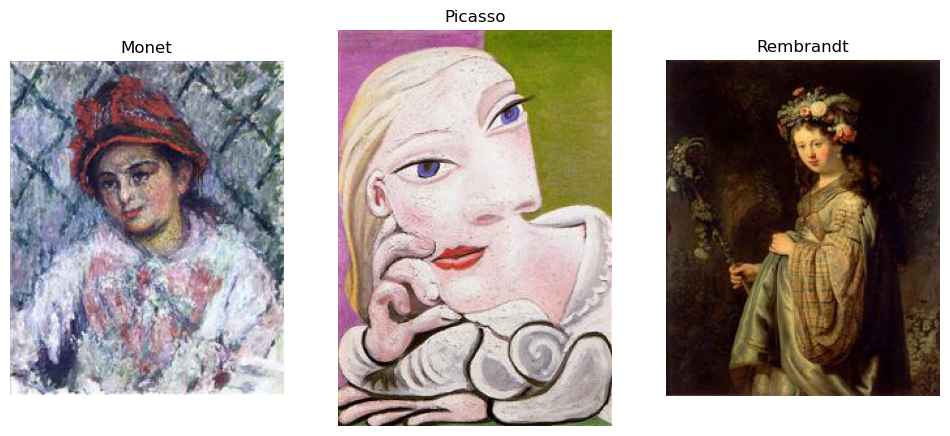

In [2]:
# sample  of images (1)
fig, ax = plt.subplots(1,3, figsize=(12,8))

monet = plt.imread('Paintings/Training/Monet/blanche-hoschede.jpg!PinterestSmall.jpg')
picasso = plt.imread('Paintings/Training/Picasso/marie-therese-leaning-1939.jpg!PinterestSmall.jpg')
rembrandt = plt.imread('Paintings/Training/Rembrandt/flora-1634.jpg!PinterestSmall.jpg')

ax[0].imshow(monet)
ax[0].axis('off')
ax[0].set_title('Monet')

ax[1].imshow(picasso)
ax[1].axis('off')
ax[1].set_title('Picasso')

ax[2].imshow(rembrandt)
ax[2].axis('off')
ax[2].set_title('Rembrandt');

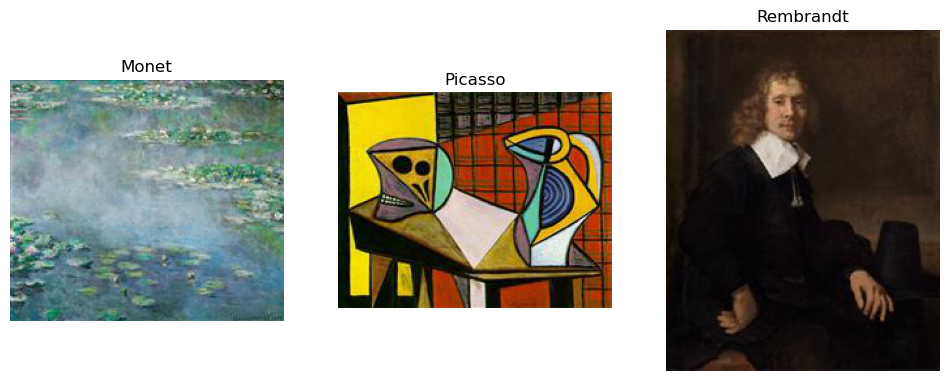

In [3]:
# sample  of images (2)
fig, ax = plt.subplots(1,3, figsize=(12,8))

monet = plt.imread('Paintings/Training/Monet/water-lilies-13.jpg!PinterestSmall.jpg')
picasso = plt.imread('Paintings/Training/Picasso/crane-and-pitcher-1945.jpg!PinterestSmall.jpg')
rembrandt = plt.imread('Paintings/Training/Rembrandt/a-young-man-at-a-table-possibly-govaert-flinck-1660.jpg!PinterestSmall.jpg')

ax[0].imshow(monet)
ax[0].axis('off')
ax[0].set_title('Monet')

ax[1].imshow(picasso)
ax[1].axis('off')
ax[1].set_title('Picasso')

ax[2].imshow(rembrandt)
ax[2].axis('off')
ax[2].set_title('Rembrandt');

## Section 3 - The Image Classifier

### 3.1 - Preprocessing/Transformation

In [4]:
def preprocessing(transformer):
    # set seed
    np.random.seed(30224)

    # create training/test datasets using ImageFolder
    training_data = torchvision.datasets. \
                        ImageFolder(root='Paintings/Training/',
                                    transform=transformer)

    test_data = torchvision.datasets. \
                        ImageFolder(root='Paintings/Test/',
                                    transform=transformer)

    # dataloader for batch size of 64 using the random samplers
    train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)
    
    # return dataloaders
    return train_dataloader, test_dataloader

### 3.2 - The Convolutional Neural Network

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Sequential Layer 1 from 3x256x256 to 16x128x128
        self.layer1 = nn.Sequential(  
            nn.Conv2d(in_channels=3, out_channels=16, 
                      kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16), 
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2))
        
        # Sequential Layer 2 to 32x64x64
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, 
                      kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2))
        
        # Sequential Layer 3 to 128x32x32
        self.layer3 = nn.Sequential(
            
            # first convolution into 64 channels
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64), 
            
            # second convolution into 128 channels
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128), 
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # overall dropout for this sequential layer
            nn.Dropout(p=0.2))
        
        # Fully-connected Layer
        self.fc = nn.Sequential(
            nn.Linear(128*32*32, 64*64),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64*64, 3*3),
            nn.LeakyReLU(),
            nn.Linear(9, 3))
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

### 3.3 - Training the CNN

In [6]:
def trainCNN(model, train_dataloader, epochs=10):
    # try forcing deterministic training
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # set seed
    np.random.seed(30224)
    
    # Use cross-entropy loss and SGD optimiser
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.SGD(model.parameters(), lr=0.001)

    train_loss = []
    
    for epoch in range(epochs):   
        st = time.time()
        for i, (imgs, lbls) in enumerate(train_dataloader):

            outputs = model(imgs)
            loss = criterion(outputs, lbls)

            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        # print out progress
        et = time.time()
        print('Epoch {}, Loss: {:.4f}, time spanned for epoch: {:.4f}'.format(epoch+1, loss.item(), et-st))
        train_loss.append(loss.item())
    
    # return a trained model and losses
    return model, train_loss

### 3.4 - Evaluation of performance

In [7]:
def evaluateCNN(model, test_dataloader):
    # set seed
    np.random.seed(30224)
    
    # evaluate model using test set and calculate the 
    # overall classification accuracy
    model.eval()

    all_lbl = []
    correct = 0; total = 0

    with torch.no_grad():
        for imgs, lbls in test_dataloader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += lbls.size(0)
            correct += (predicted==lbls).sum().item()
            all_lbl.append(predicted)
        print('Proportion of correct prediction:', correct/total)
        
    # return predicted labels
    return all_lbl

### 3.5 - Model 1 (Default)

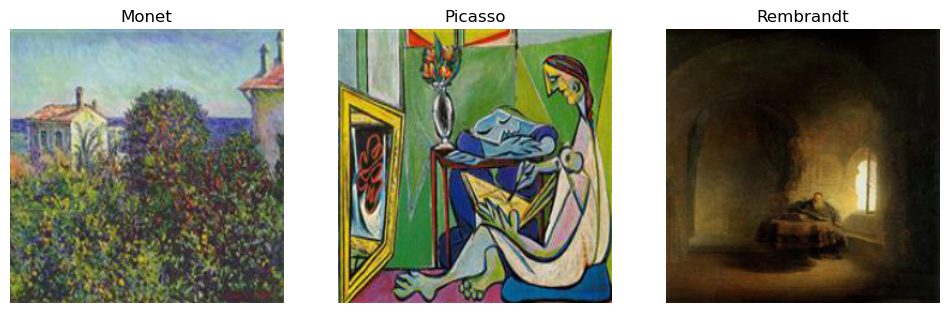

In [8]:
# transform with resize only
transformer1 = transforms.v2.Compose([
    v2.Resize([256,256], antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    ToTensor()])

# preprocess and obtain dataloaders
train_dataloader, test_dataloader = preprocessing(transformer1)

# sample of transformed images in model 1
fig, ax = plt.subplots(1,3, figsize=(12,8))

for i in range(3):
    ax[i].imshow(train_dataloader.dataset[i*237+14][0].permute(1,2,0))
    ax[i].axis('off')
    
ax[0].set_title('Monet')
ax[1].set_title('Picasso')
ax[2].set_title('Rembrandt');

#### Estimated running time for CNN: ~100 seconds per epoch x 10 epochs = 1000 seconds ~ 17 mins

In [9]:
# initiate model and print out number of parameters
model1 = NeuralNetwork()
print('No. of parameters:', sum(p.numel() for p in model1.parameters() if p.requires_grad))

# train model
trained_model1, train_loss1 = trainCNN(model1, train_dataloader)

# evaluate model and obtain labels
lbl_model1 = evaluateCNN(trained_model1, test_dataloader)

No. of parameters: 537182631
Epoch 1, Loss: 0.9381, time spanned for epoch: 82.0561
Epoch 2, Loss: 0.7279, time spanned for epoch: 90.1856
Epoch 3, Loss: 0.7240, time spanned for epoch: 93.8366
Epoch 4, Loss: 0.8357, time spanned for epoch: 91.8583
Epoch 5, Loss: 0.4962, time spanned for epoch: 93.2244
Epoch 6, Loss: 0.4456, time spanned for epoch: 92.0640
Epoch 7, Loss: 0.5149, time spanned for epoch: 93.7144
Epoch 8, Loss: 0.2262, time spanned for epoch: 94.3648
Epoch 9, Loss: 0.9033, time spanned for epoch: 92.9333
Epoch 10, Loss: 0.4999, time spanned for epoch: 97.5055
Proportion of correct prediction: 0.8


### 3.6 - Model 2 (Extra Preprocessing with Gaussian Blur and Random Horizontal Flip)

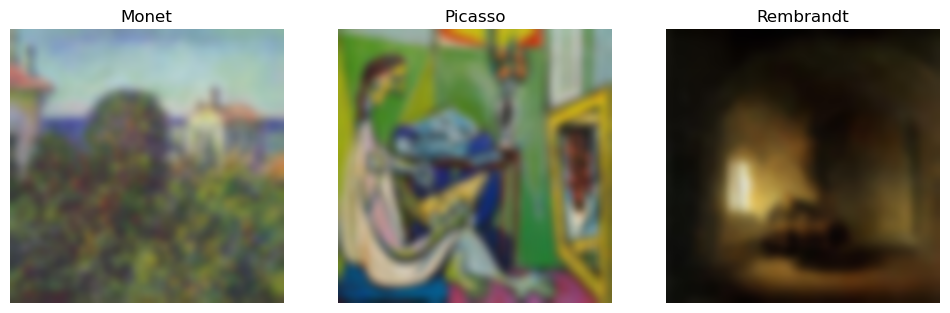

In [10]:
# transform with resize and gaussian blur
transformer2 = transforms.v2.Compose([
    v2.Resize([256,256], antialias=True),
    v2.GaussianBlur(kernel_size=17, sigma=(4,4)), 
    v2.RandomHorizontalFlip(0.5), 
    v2.ToDtype(torch.float32, scale=True),
    ToTensor()])

# preprocess and obtain dataloaders
train_dataloader, test_dataloader = preprocessing(transformer2)

# sample of transformed images in model 2
fig, ax = plt.subplots(1,3, figsize=(12,8))

for i in range(3):
    ax[i].imshow(train_dataloader.dataset[i*237+14][0].permute(1,2,0))
    ax[i].axis('off')
    
ax[0].set_title('Monet')
ax[1].set_title('Picasso')
ax[2].set_title('Rembrandt');

#### Estimated running time for CNN: ~100 seconds per epoch x 10 epochs = 1000 seconds ~ 17mins

In [11]:
# initiate model and train
model2 = NeuralNetwork()
trained_model2, train_loss2 = trainCNN(model2, train_dataloader)

Epoch 1, Loss: 0.9613, time spanned for epoch: 96.3434
Epoch 2, Loss: 0.8344, time spanned for epoch: 95.6453
Epoch 3, Loss: 0.6622, time spanned for epoch: 98.1197
Epoch 4, Loss: 0.6040, time spanned for epoch: 97.1940
Epoch 5, Loss: 1.1184, time spanned for epoch: 96.5772
Epoch 6, Loss: 0.7386, time spanned for epoch: 98.2654
Epoch 7, Loss: 0.4482, time spanned for epoch: 96.1909
Epoch 8, Loss: 1.0403, time spanned for epoch: 97.7946
Epoch 9, Loss: 0.4718, time spanned for epoch: 97.5645
Epoch 10, Loss: 0.4264, time spanned for epoch: 100.7899


In [12]:
# evaluate model and obtain labels
lbl_model2 = evaluateCNN(trained_model2, test_dataloader)

Proportion of correct prediction: 0.675


### 3.7 - Model 3 (ResNet50, no extra preprocessing)

In [13]:
from torchvision.models import resnet50

In [14]:
# from 3.5 and 3.6, a simple resizing would suffice, just note that
# the image for ResNet50 has to be 224 x 224 instead of 256 x 256
transformer3 = transforms.v2.Compose([
    v2.Resize([224,224], antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    ToTensor()])

# preprocess and obtain dataloaders
train_dataloader, test_dataloader = preprocessing(transformer3)

In [15]:
# use resnet50 and adjust output features to 3 classes
model3 = resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')
model3.fc = nn.Linear(2048, 3)

# print out number of parameters that require graident computation
print('No. of parameters:',sum(p.numel() for p in model3.parameters() if p.requires_grad))

No. of parameters: 23514179


#### Estimated running time for CNN: ~240 seconds per epoch x 10 epochs = 2400 seconds ~ 40 mins

In [16]:
trained_model3, train_loss3 = trainCNN(model3, train_dataloader)

Epoch 1, Loss: 1.0863, time spanned for epoch: 234.5711
Epoch 2, Loss: 1.0972, time spanned for epoch: 229.4058
Epoch 3, Loss: 1.0453, time spanned for epoch: 230.7167
Epoch 4, Loss: 1.0240, time spanned for epoch: 234.7771
Epoch 5, Loss: 1.0291, time spanned for epoch: 228.8040
Epoch 6, Loss: 0.8916, time spanned for epoch: 231.2856
Epoch 7, Loss: 0.9289, time spanned for epoch: 232.7285
Epoch 8, Loss: 0.9477, time spanned for epoch: 236.6877
Epoch 9, Loss: 0.8351, time spanned for epoch: 236.3217
Epoch 10, Loss: 0.7919, time spanned for epoch: 235.6303


In [17]:
# evaluate model and obtain labels
lbl_model3 = evaluateCNN(trained_model3, test_dataloader)

Proportion of correct prediction: 0.9083333333333333


### 3.8 - Confusion Matrices

In [18]:
# for visualisation of heatmap of a confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [19]:
# compute confusion matrices for the models
# obtain true labels
true_label = np.array(test_dataloader.dataset.targets)

# predicted labels by model1
pred_label1 = lbl_model1[0].tolist()
pred_label1.extend(lbl_model1[1].tolist())
pred_label1 = np.array(pred_label1)
cm1 = confusion_matrix(true_label, pred_label1)

# predicted labels by model2
pred_label2 = lbl_model2[0].tolist()
pred_label2.extend(lbl_model2[1].tolist())
pred_label2 = np.array(pred_label2)
cm2 = confusion_matrix(true_label, pred_label2)

# predicted labels by model3
pred_label3 = lbl_model3[0].tolist()
pred_label3.extend(lbl_model3[1].tolist())
pred_label3 = np.array(pred_label3)
cm3 = confusion_matrix(true_label, pred_label3)

#### Note: PyTorch is not fully deterministic, the misclassification may vary.

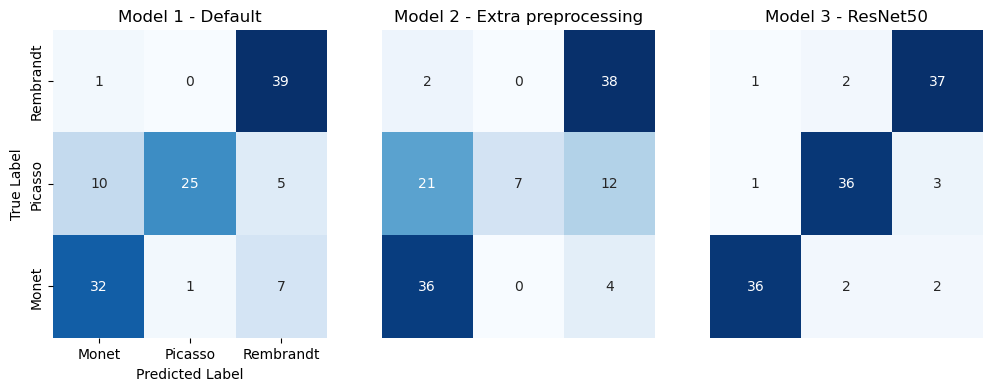

In [20]:
# visualisation of the confusion matrix
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax = ax.flatten()

for i, cm in enumerate([cm1, cm2, cm3]):
    sns.heatmap(cm, annot=True, cbar=False, cmap='Blues', ax=ax[i])
    ax[i].set_xlim(0,3); ax[i].set_ylim(0,3)
    ax[i].set_xticklabels(['Monet','Picasso','Rembrandt'])
    ax[i].set_yticklabels(['Monet','Picasso','Rembrandt'])
    ax[i].set_xlabel('Predicted Label'); ax[i].set_ylabel('True Label')
    
ax[0].set_title('Model 1 - Default')
ax[1].set_title('Model 2 - Extra preprocessing')
ax[2].set_title('Model 3 - ResNet50')
ax[1].axis('off'); ax[2].axis('off');

#### Note: on occasions, there could be no misclassification in some groups below.  Please adjust the variables and the number of columns in the plots.

#### Model 1

In [21]:
# locations of misclassified images
mon_rem = (np.array(true_label)==0) & (np.array(pred_label1)==2)
pic_mon = (np.array(true_label)==1) & (np.array(pred_label1)==0)
pic_rem = (np.array(true_label)==1) & (np.array(pred_label1)==2)
rem_mon = (np.array(true_label)==2) & (np.array(pred_label1)==0)

print(np.argwhere(mon_rem).flatten(), 'count:', sum(mon_rem))
print(np.argwhere(pic_mon).flatten(), 'count:', sum(pic_mon))
print(np.argwhere(pic_rem).flatten(), 'count:', sum(pic_rem))
print(np.argwhere(rem_mon).flatten(), 'count:', sum(rem_mon))

[10 12 17 28 34 35 39] count: 7
[44 45 46 53 57 62 65 70 72 74] count: 10
[50 54 58 64 77] count: 5
[116] count: 1


In [24]:
# sample some misclassified images
np.random.seed(30224)
mis_cls = np.array([])
mis_cls = np.append(mis_cls, np.random.choice(np.argwhere(mon_rem).flatten()))
mis_cls = np.append(mis_cls, np.random.choice(np.argwhere(pic_mon).flatten()))
mis_cls = np.append(mis_cls, np.random.choice(np.argwhere(pic_rem).flatten()))
mis_cls = np.append(mis_cls, np.random.choice(np.argwhere(rem_mon).flatten()))
mis_cls = mis_cls.astype('int')

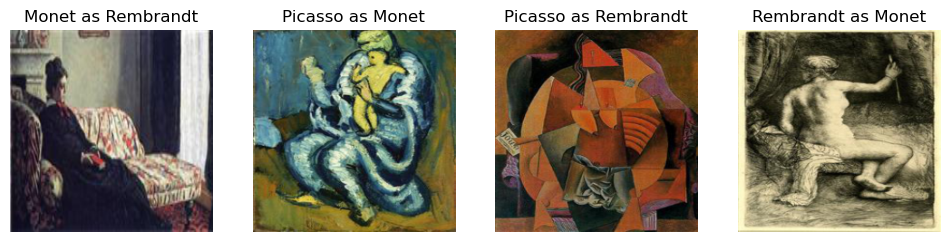

In [26]:
# visualise some misclassifieid images
np.random.seed(30224)
fig, ax = plt.subplots(1,4, figsize=(12,6))

for j in range(4):
    ax[j].imshow(test_dataloader.dataset[mis_cls[j]][0].permute(1,2,0))
    ax[j].axis('off')
    
ax[0].set_title('Monet as Rembrandt')
ax[1].set_title('Picasso as Monet')
ax[2].set_title('Picasso as Rembrandt');
ax[3].set_title('Rembrandt as Monet');

#### Model 3

In [27]:
# locations of misclassified images
mon_rem = (np.array(true_label)==0) & (np.array(pred_label3)==2)
pic_mon = (np.array(true_label)==1) & (np.array(pred_label3)==0)
pic_rem = (np.array(true_label)==1) & (np.array(pred_label3)==2)
rem_mon = (np.array(true_label)==2) & (np.array(pred_label3)==0)

print(np.argwhere(mon_rem).flatten(), 'count:', sum(mon_rem))
print(np.argwhere(pic_mon).flatten(), 'count:', sum(pic_mon))
print(np.argwhere(pic_rem).flatten(), 'count:', sum(pic_rem))
print(np.argwhere(rem_mon).flatten(), 'count:', sum(rem_mon))

[10 11] count: 2
[57] count: 1
[64 68 72] count: 3
[109] count: 1


In [29]:
# sample some misclassified images
np.random.seed(30224)
mis_cls3 = np.array([])
mis_cls3 = np.append(mis_cls3, np.random.choice(np.argwhere(mon_rem).flatten()))
mis_cls3 = np.append(mis_cls3, np.random.choice(np.argwhere(pic_mon).flatten()))
mis_cls3 = np.append(mis_cls3, np.random.choice(np.argwhere(pic_rem).flatten()))
mis_cls3 = np.append(mis_cls3, np.random.choice(np.argwhere(rem_mon).flatten()))
mis_cls3 = mis_cls3.astype('int')

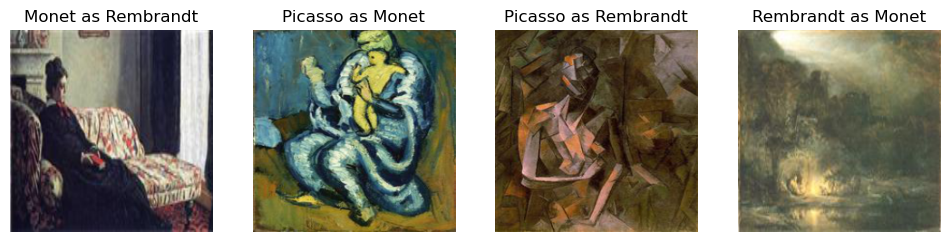

In [30]:
# visualise some misclassifieid images
np.random.seed(30224)
fig, ax = plt.subplots(1,4, figsize=(12,6))

for j in range(4):
    ax[j].imshow(test_dataloader.dataset[mis_cls3[j]][0].permute(1,2,0))
    ax[j].axis('off')
    
ax[0].set_title('Monet as Rembrandt')
ax[1].set_title('Picasso as Monet')
ax[2].set_title('Picasso as Rembrandt');
ax[3].set_title('Rembrandt as Monet');

## Section 4 - Clustering Analysis

### 4.1 Selection of Filters

In [31]:
# use the skimage package
import skimage as ski

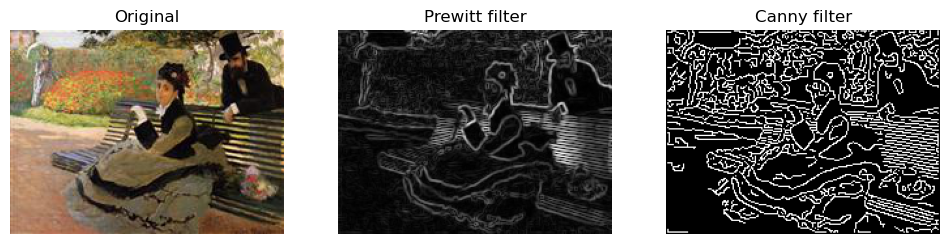

In [32]:
# plot original, Prewitt filtered and Canny filtered images
fig, ax = plt.subplots(1,3, figsize=(12,8))
ax = ax.flatten()

img3 = plt.imread('Paintings/Training/Monet/camille-monet-on-a-garden-bench.jpg!PinterestSmall.jpg')
img3_fil = ski.color.rgb2gray(img3)
img3_can = ski.feature.canny(img3_fil)
img3_pre = ski.filters.prewitt(img3_fil)

ax[0].imshow(img3, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(img3_pre, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prewitt filter')

ax[2].imshow(img3_can, cmap='gray')
ax[2].axis('off')
ax[2].set_title('Canny filter');

In [33]:
# use the default training data
train_dataloader, test_dataloader = preprocessing(transformer1)

# apply Prewitt filter to all training images and
# convert into a flattened array as an entry of a dataframe
# i.e. each image is grayscaled and pixels become columns

grayscale = []
for i in range(len(train_dataloader.dataset)):
    temp = ski.color.rgb2gray(train_dataloader.dataset[i][0].permute(1,2,0))
    temp = ski.filters.prewitt(temp)
    grayscale.append(temp.flatten())
    
df_filter = pd.DataFrame(np.array(grayscale))

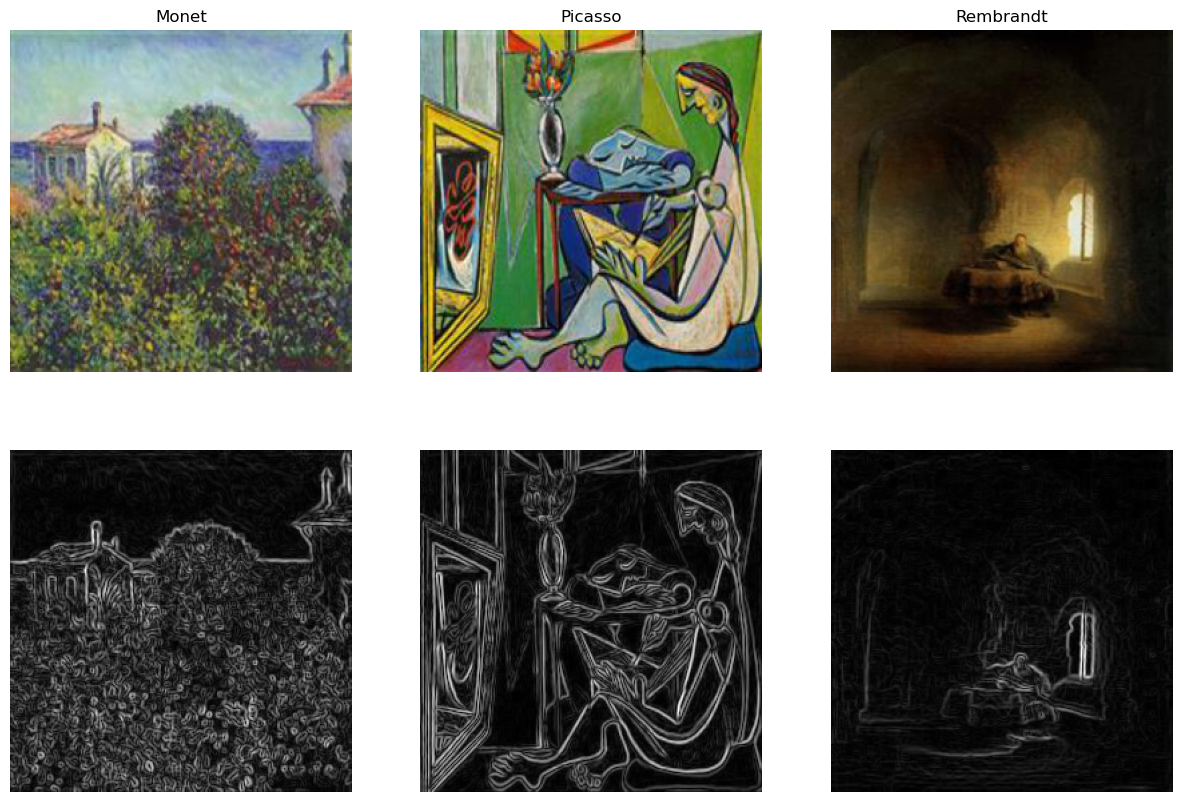

In [34]:
# plot original and Prewitt filtered images
fig, ax = plt.subplots(2,3, figsize=(15,10))
for i in range(3):
    ax[0][i].imshow(train_dataloader.dataset[i*237+14][0].permute(1,2,0))
    ax[1][i].imshow(df_filter.iloc[i*237+14].values.reshape(256, 256), cmap='gray')
    ax[0][i].axis('off'); ax[1][i].axis('off'); 
    
ax[0][0].set_title('Monet')
ax[0][1].set_title('Picasso')
ax[0][2].set_title('Rembrandt');

### 4.2 - Dimension Reduction

In [35]:
# for visualisation in reduced dimensions
from sklearn.decomposition import PCA, KernelPCA

In [36]:
# ordinary PCA
pca = PCA(n_components=30, random_state=30224)
pca.fit(df_filter)
pc = pca.transform(df_filter)

In [37]:
# percentage of variance explained by the first 30 PCs
sum(pca.explained_variance_ratio_)

0.3691858039237559

In [38]:
# RBF Kernal PCA
kpca = KernelPCA(n_components=30, kernel='rbf', random_state=30224, gamma=0.005)
kpca.fit(df_filter)
kpc = kpca.transform(df_filter)

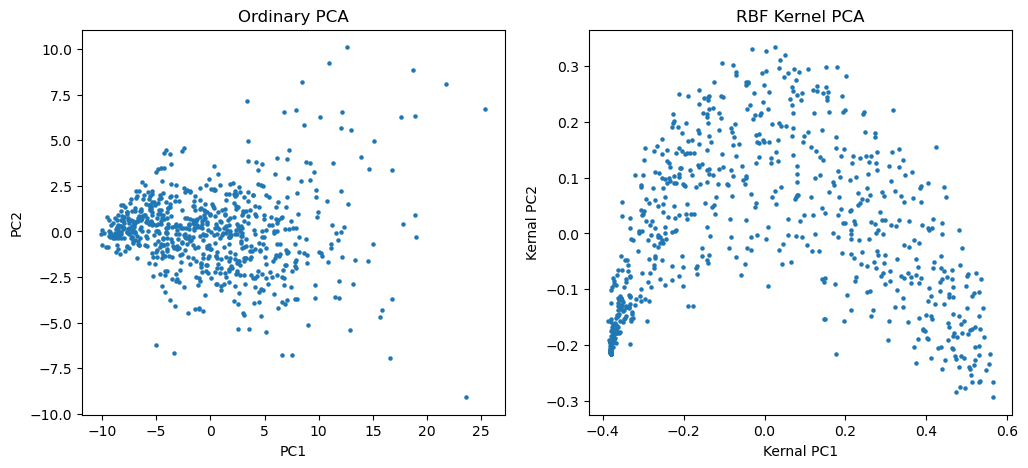

In [39]:
# observations in 2 dimensions
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(pc[:,0], pc[:,1], s=5)
ax[0].set_xlabel('PC1'); ax[0].set_ylabel('PC2')
ax[0].set_title('Ordinary PCA')

ax[1].scatter(kpc[:,0], kpc[:,1], s=5)
ax[1].set_xlabel('Kernal PC1'); ax[1].set_ylabel('Kernal PC2')
ax[1].set_title('RBF Kernel PCA');

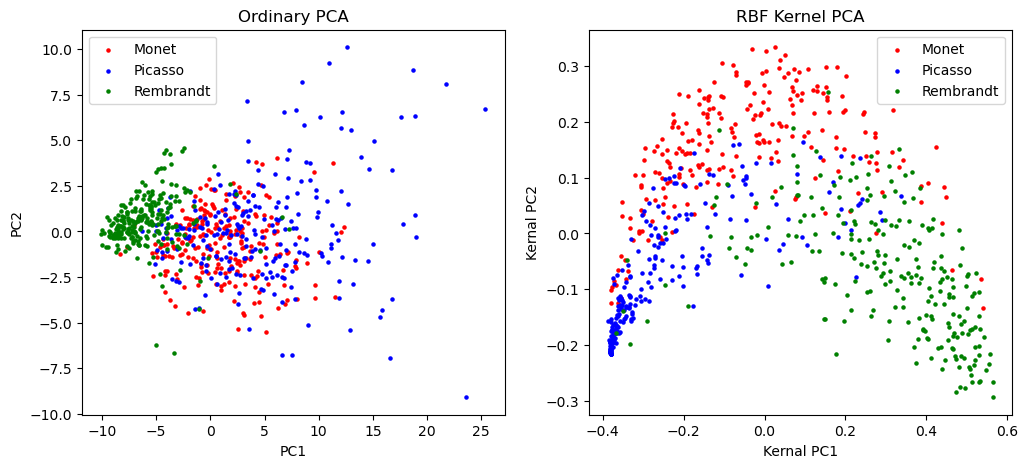

In [40]:
# Visualise by artists
col = ['red','blue','green']
lbl = ['Monet','Picasso','Rembrandt']
fig, ax = plt.subplots(1,2,figsize=(12,5))

# using the fact that each artist has 237 training paintings in sequence
for i in range(3):
    ax[0].scatter(pc[237*i:237*(i+1),0], pc[237*i:237*(i+1),1], c=col[i], s=5, label=lbl[i])
    ax[0].set_xlabel('PC1'); ax[0].set_ylabel('PC2')
    ax[0].set_title('Ordinary PCA'); ax[0].legend()

for i in range(3):
    ax[1].scatter(kpc[237*i:237*(i+1),0], kpc[237*i:237*(i+1),1], c=col[i], s=5, label=lbl[i])
    ax[1].set_xlabel('Kernal PC1'); ax[1].set_ylabel('Kernal PC2')
    ax[1].set_title('RBF Kernel PCA'); ax[1].legend();

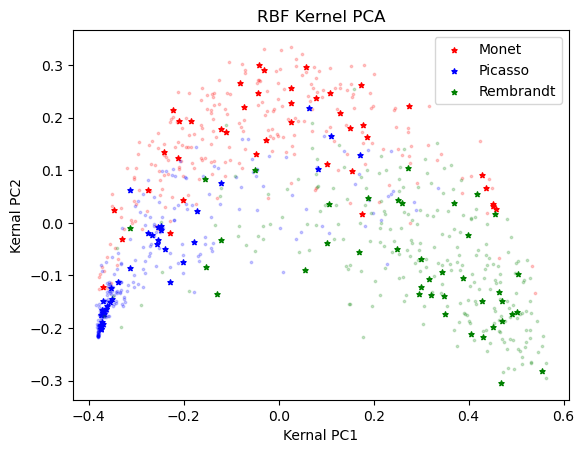

In [41]:
# visualise test data
grayscale = []
for i in range(len(test_dataloader.dataset)):
    temp = ski.color.rgb2gray(test_dataloader.dataset[i][0].permute(1,2,0))
    temp = ski.filters.prewitt(temp)
    grayscale.append(temp.flatten())
    
df_filter_test = pd.DataFrame(np.array(grayscale))

kpc2 = kpca.transform(df_filter_test)

for i in range(3):
    plt.scatter(kpc2[40*i:40*(i+1),0], kpc2[40*i:40*(i+1),1], c=col[i], s=15, label=lbl[i], marker='*')
    plt.scatter(kpc[237*i:237*(i+1),0], kpc[237*i:237*(i+1),1], c=col[i], s=3, alpha=0.2)
    plt.xlabel('Kernal PC1'); plt.ylabel('Kernal PC2')
    plt.title('RBF Kernel PCA'); plt.legend();

### 4.3 - KMeans Clustering

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### Estimated running time for KMeans clustering: < 1 min

In [43]:
# run kmeans and estimate the best number of clusters
# by both inertia and silhouette score
# set seed
np.random.seed(30224)

inertia = []; sil = []

st = time.time()

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=30224)
    kmeans.fit(kpc)
    sil.append(silhouette_score(kpc, kmeans.labels_))
    inertia.append(kmeans.inertia_)

et = time.time()
print(et-st)

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

19.281054258346558


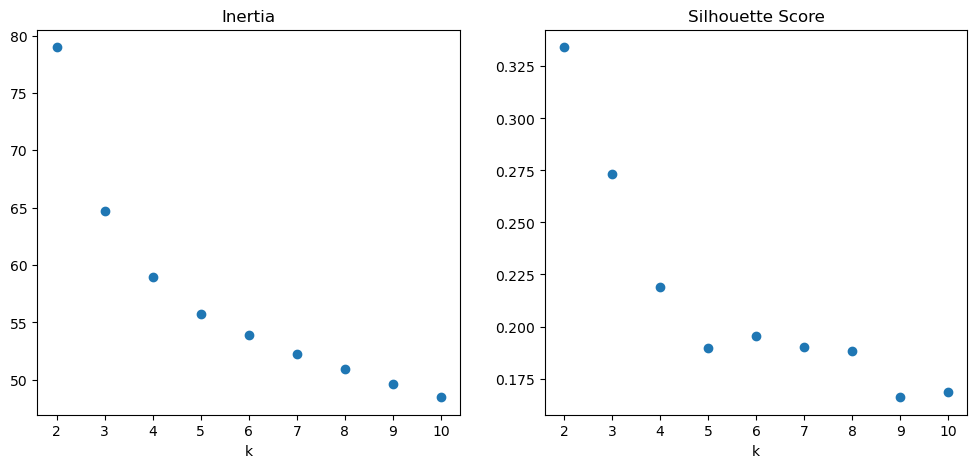

In [44]:
# plot inertia and silhouette score
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(range(2,11), inertia)
ax[0].set_title('Inertia')
ax[0].set_xlabel('k')
ax[1].scatter(range(2,11), sil)
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('k');

#### Note: The KMeans result is not very conclusive and hence not further proceeded.

### 4.4 - Hierarchical Clustering

In [45]:
from sklearn.cluster import AgglomerativeClustering as HC

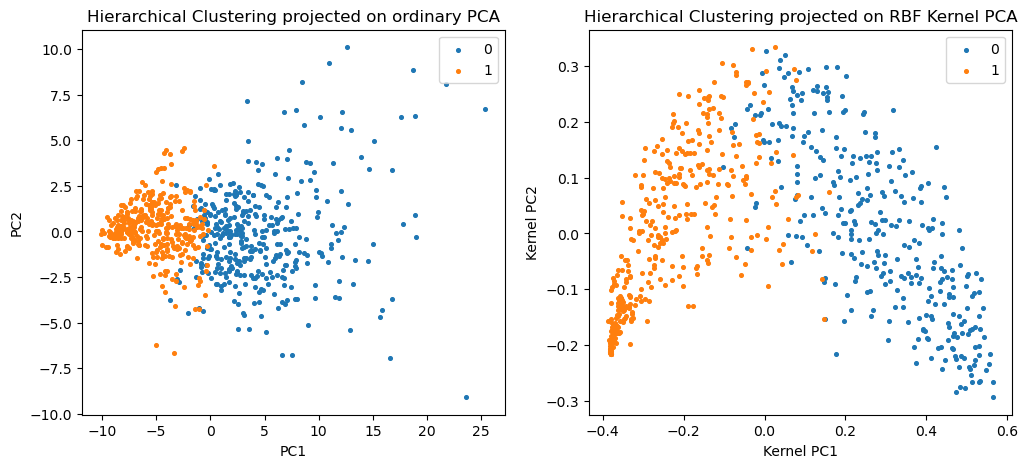

In [53]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

# Hierarchical Clustering on Ordinary PCA, default 2 clusters
hc = HC(linkage='ward')
hc.fit(pc)
hlabels = hc.labels_

for i in range(len(set(hlabels))):
    mask = hlabels == i
    ax[0].scatter(pc[mask,0], pc[mask,1], s=7, label=str(i))
    ax[0].set_xlabel('PC1'); ax[0].set_ylabel('PC2')
    ax[0].set_title('Hierarchical Clustering projected on ordinary PCA'); ax[0].legend();

# Hierarchical Clustering on Kernal PCA, default 2 clusters
khc = HC(linkage='ward')
khc.fit(kpc)
khlabels = khc.labels_

for i in range(len(set(khlabels))):
    mask = khlabels == i
    ax[1].scatter(kpc[mask,0], kpc[mask,1], s=7, label=str(i))
    ax[1].set_xlabel('Kernel PC1'); ax[1].set_ylabel('Kernel PC2')
    ax[1].set_title('Hierarchical Clustering projected on RBF Kernel PCA'); ax[1].legend();

In [47]:
# print counts
df_filter2 = df_filter.copy()
df_filter2['label'] = khlabels
df_filter2['label'].value_counts()

label
1    388
0    323
Name: count, dtype: int64

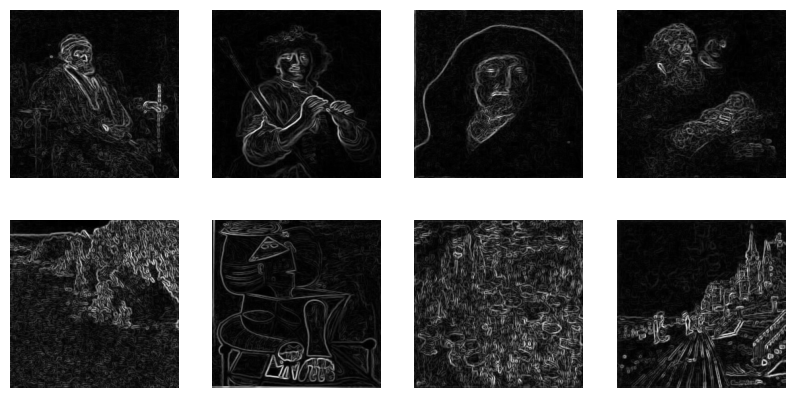

In [48]:
fig, ax = plt.subplots(2, 4, figsize=(10,5))
for i in range(2):
    np.random.seed(30224)
    mask = df_filter2['label'] == i
    idx = df_filter2[mask].sample(4).index
    for j,k in enumerate(idx):
        ax[i][j].imshow(df_filter.iloc[k].values.reshape(256,256), cmap='gray')
        ax[i][j].axis('off')

### 4.5 - TSNE

In [49]:
from sklearn.manifold import TSNE

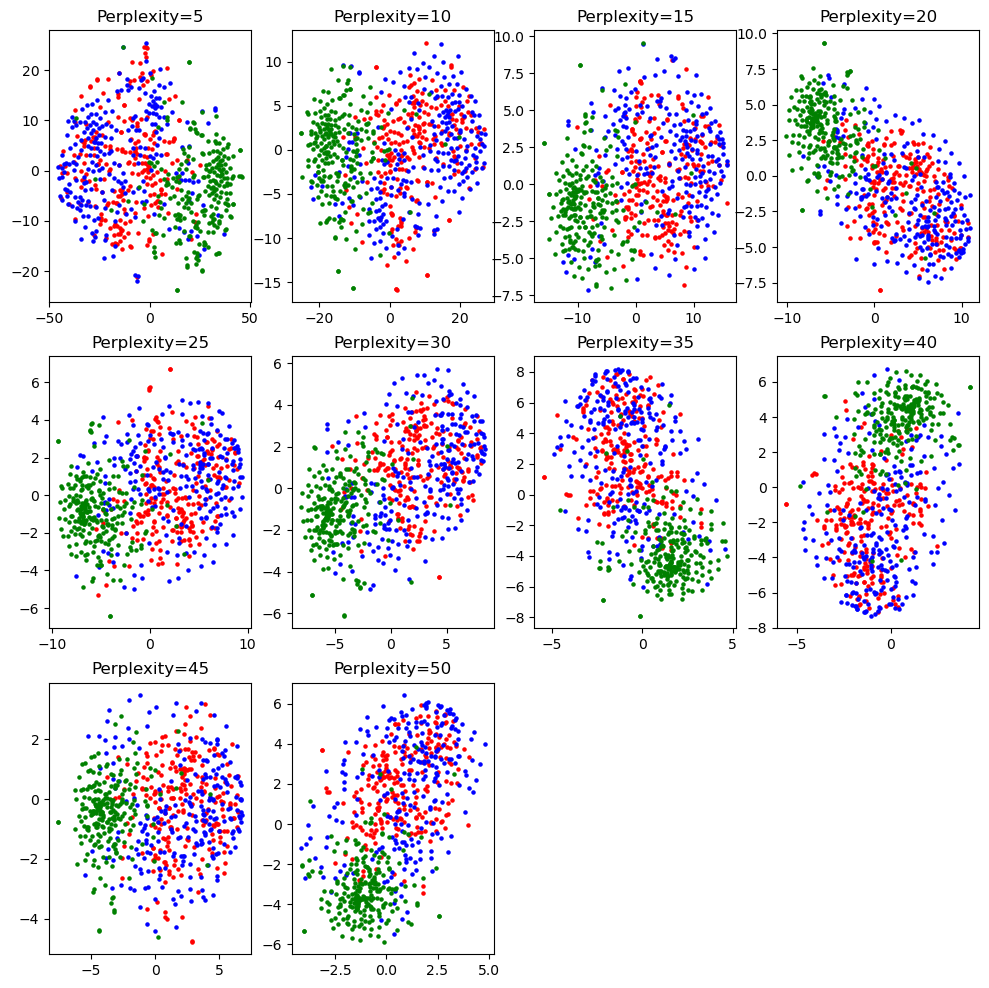

In [50]:
# visualise TSNE results by artist
fig, ax = plt.subplots(3,4,figsize=(12,12))
ax = ax.flatten()

for j, p in enumerate(range(5, 55, 5)):
    tsne = TSNE(perplexity=p, random_state=30224)
    df_tsne = tsne.fit_transform(df_filter)

    for i in range(3):
        ax[j].scatter(df_tsne[:,0][(i*237):((i+1)*237)], df_tsne[:,1][(i*237):((i+1)*237)], s=5, c=col[i])
        ax[j].set_title('Perplexity='+str(p))

ax[10].axis('off'); ax[11].axis('off');

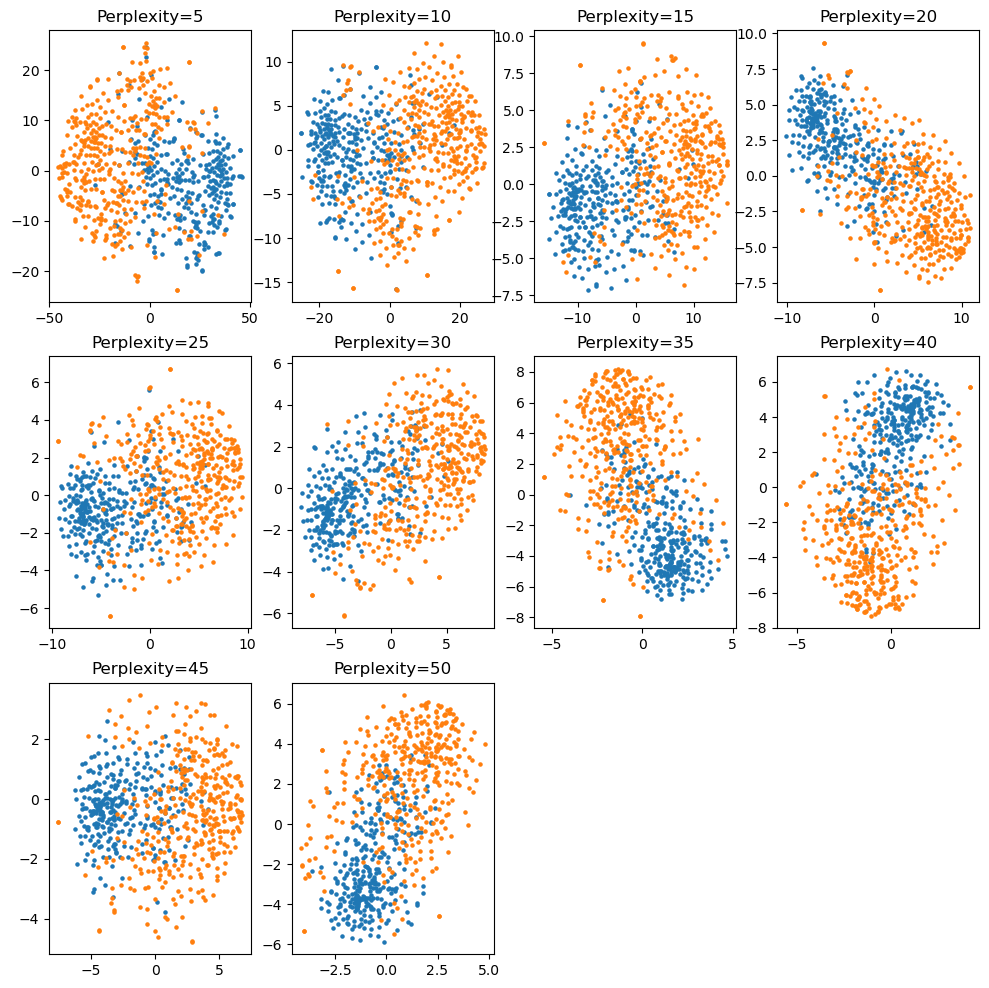

In [51]:
# visualise TSNE results by Hierarchical Clustering
fig, ax = plt.subplots(3,4,figsize=(12,12))
ax = ax.flatten()

for j, p in enumerate(range(5, 55, 5)):
    tsne = TSNE(perplexity=p, random_state=30224)
    df_tsne = tsne.fit_transform(df_filter)

    for i in range(2):
        mask = khlabels == i
        ax[j].scatter(df_tsne[:,0][mask], df_tsne[:,1][mask], s=5)
        ax[j].set_title('Perplexity='+str(p))

ax[10].axis('off'); ax[11].axis('off');